In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import config
from src import load_data
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [29]:
data = load_data(config.PROCESSED_FILE).copy()


data["date"] = pd.to_datetime(data["date"])
data.set_index("date",inplace=True)

data.head()

Données chargées avec succès.


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,is_holiday,is_weekend,season,time_of_the_day,is_school_holiday
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,7.000000,63.000000,5.3,13.275433,13.275433,False,False,3,0.708333,False
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,6.666667,59.166667,5.2,18.606195,18.606195,False,False,3,0.715278,False
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,6.333333,55.333333,5.1,28.642668,28.642668,False,False,3,0.722222,False
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,6.000000,51.500000,5.0,45.410389,45.410389,False,False,3,0.729167,False
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,5.666667,47.666667,4.9,10.084097,10.084097,False,False,3,0.736111,False


In [6]:
def borne_min(array,valeur_borne):
    return (array>=valeur_borne)*array+(array<=valeur_borne)*valeur_borne

borne_min(np.array([1,0,2,5,7]),0.5)

array([1. , 0.5, 2. , 5. , 7. ])

In [28]:

t = np.arange(len(data))

X = pd.DataFrame({"Temps": t,"Sin_day": np.sin((2*np.pi*(t))/142),"intercept": np.ones((len(data),))})

variables_explicatives_list = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'is_holiday',
        'is_school_holiday']

for j in range(24):
    X[f'is_{j+1}th_hour'] = (data.index.hour == j).astype(int)
        
for j in range(7):    
    X[f'is_{j+1}th_day'] = (data.index.day == j).astype(int)


X[variables_explicatives_list] = data[variables_explicatives_list].copy().to_numpy()

y = data["Appliances"].copy()

train_index = (data.index <= "2016-04-27 18:00:00").sum()


In [26]:
def mape(y_test,y_pred):
    return np.mean(np.abs((y_test-y_pred)/y_test))

def rmse(y_test,y_pred):
    return np.mean((y_test-y_pred)**2)**0.5


def plot_model(model="Linear",l1_ratio=0.5,alpha=1):
    if model not in ["Linear","Elastic_net"]:
        raise ValueError("If have to choose either 'Linear' or 'Elastic_net'")
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    
    if model == "Linear":
        model1 = LinearRegression()
        model1.fit(X_train,y_train)

    elif model == "Elastic_net":
        model1 = ElasticNet(l1_ratio=l1_ratio,alpha=alpha)
        model1.fit(X_train,y_train)

    y_pred = borne_min(model1.predict(X_test),np.min(X_train))

    print(f"Le MAPE est {mape(y_test.to_numpy(),y_pred)}")
    print(f"Le RMSE est {rmse(y_test.to_numpy(),y_pred)}")

    if model == "Elastic_net":
        fig = go.Figure()

# Add the second line
        fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_test, mode='lines', name='Test'))

# Add the first line
        fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_pred, mode='lines', name='Prédiction'))

# Customize layout
        fig.update_layout(
        title=f"Prédiction {model}\n avec l1 = {l1_ratio} et alpha = {alpha}",
        xaxis_title="X-axis Label",
        yaxis_title="Y-axis Label",
        legend_title="Legend",
        template="plotly_white")

# Show the plot
        fig.show()


    else:
        fig = go.Figure()

# Add the second line
        fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_test, mode='lines', name='Test'))

# Add the first line
        fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_pred, mode='lines', name='Prédiction'))

# Customize layout
        fig.update_layout(
        title=f"Prédiction {model}",
        xaxis_title="X-axis Label",
        yaxis_title="Y-axis Label",
        legend_title="Legend",
        template="plotly_white")

# Show the plot
        fig.show()

        return y_pred    


In [34]:
def plot_online_model(model="Linear",l1_ratio=0.5,alpha=1,figure = True):

    if model not in ["Linear","Elastic_net"]:
        raise ValueError("If have to choose either 'Linear' or 'Elastic_net'")


    
    def train_and_predict(X, y, model, l1_ratio = l1_ratio, alpha = alpha):


        step = 144 
        days = 1 
        total_steps = step * days
    
    
        y_pred = []
    
        for j in range(0, len(data) - train_index, total_steps):
            X_train, y_train = X.iloc[:train_index + j], y[:train_index + j]
            X_test = X.iloc[train_index + j:train_index + j + total_steps]
            
            model1 = ElasticNet(l1_ratio=l1_ratio, alpha=alpha) if model == "Elastic_net" else LinearRegression()
            model1.fit(X_train, y_train)
            y_pred.append(borne_min(model1.predict(X_test),np.min(y_train)))
    
        return y_pred

# Partie principale

    y_pred = train_and_predict(X, y,l1_ratio, alpha,model)


    y_pred = np.hstack(y_pred)

    print(f"Le MAPE est {mape(y[train_index:train_index+len(y_pred)],y_pred)}")
    print(f"Le RMSE est {rmse(y_pred,y[train_index:train_index+len(y_pred)])}")

    if figure == True:
        fig = go.Figure()

# Add the second line
        fig.add_trace(go.Scatter(x=data.index[train_index:train_index+len(y_pred)], y=y[train_index:train_index+len(y_pred)], mode='lines', name='Test'))

# Add the first line
        fig.add_trace(go.Scatter(x=data.index[train_index:train_index+len(y_pred)], y=y_pred, mode='lines', name='Prédiction'))

# Customize layout
        fig.update_layout(
title=f"Prédiction {model}",
xaxis_title="X-axis Label",
yaxis_title="Y-axis Label",
legend_title="Legend",
template="plotly_white")

# Show the plot
        fig.show()  

    return y_pred

On cherche les contraintes l1 l2 optimale sur la base de données d'entrainements:

In [32]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

train_index = (data.index <= "2016-04-27 18:00:00").sum()
X_train, y_train = X.iloc[:train_index], y[:train_index]
# Elastic Net model
model = ElasticNet(random_state=42)

# Hyperparameter grid
param_distributions = {
    "alpha": np.logspace(-4, 1, 50),  # Regularization strength
    "l1_ratio": np.linspace(0, 1, 50),  # Mix of L1 and L2 regularization
}

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of random combinations
    scoring="neg_mean_squared_error",  # Metric
    cv=tscv,  # Sequential cross-validation
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X, y)

# Best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'l1_ratio': np.float64(0.8163265306122448), 'alpha': np.float64(0.09102981779915217)}


In [35]:
plot_online_model(model="Elastic_net",l1_ratio=0.8163265306122448,alpha=0.09102981779915217)

Le MAPE est 0.4829454266933625
Le RMSE est 84.33619669032275


array([158.21392791, 182.44127732, 188.42592262, ..., 176.20235173,
       174.09565693, 188.25959797])

In [11]:
import plotly.express as px


# Create an interactive line plot
fig = px.line(data, x="date", y="Appliances", title="Interactive Time Series Plot")


# Show the plot
fig.show()


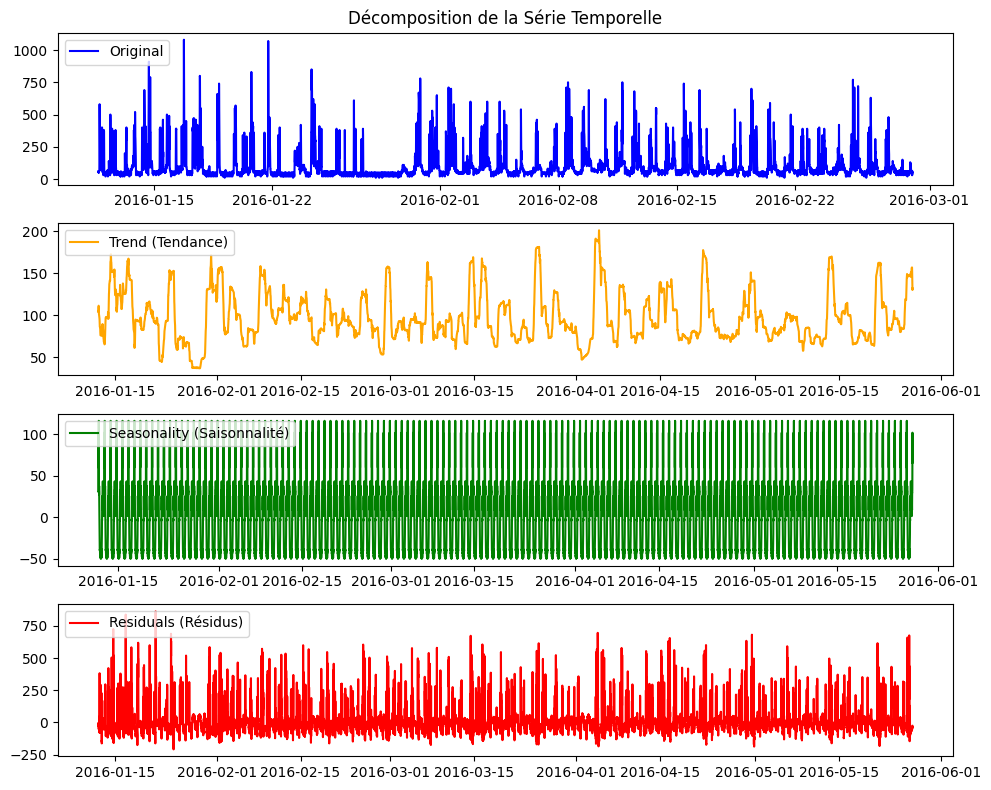

In [12]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


df = data.copy()
df.set_index("date",inplace=True)

df['day_of_week'] = df.index.dayofweek  # 0=Lundi, 6=Dimanche
df['hour'] = df.index.hour

# Décomposition de la série temporelle
result = seasonal_decompose(df['Appliances'], model='additive', period=144)

# Création d'un graphique combiné
plt.figure(figsize=(10, 8))

# Graphique de la série originale
plt.subplot(4, 1, 1)
plt.plot(df.loc[df.index.isocalendar().week<=8,'Appliances'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Décomposition de la Série Temporelle')

# Graphique de la tendance
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend (Tendance)', color='orange')
plt.legend(loc='upper left')

# Graphique de la saisonnalité
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality (Saisonnalité)', color='green')
plt.legend(loc='upper left')

# Graphique des résidus
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals (Résidus)', color='red')
plt.legend(loc='upper left')

# Ajustements et affichage
plt.tight_layout()
plt.show()

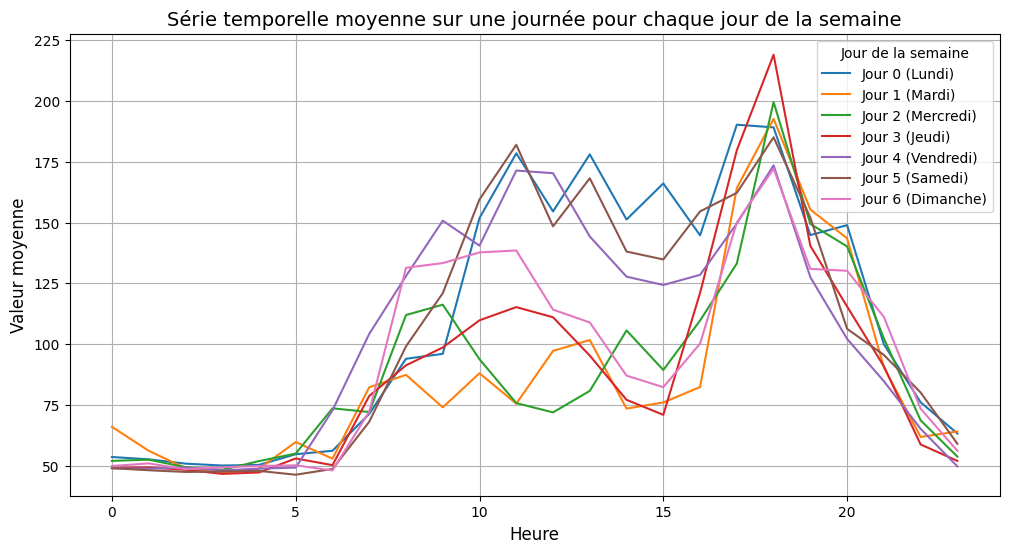

In [13]:
df['day_of_week'] = df.index.dayofweek  # 0=Lundi, 6=Dimanche
df['hour'] = df.index.hour

# Calculer la moyenne pour chaque jour de la semaine et chaque heure
average_per_hour = df.groupby(['day_of_week', 'hour'])['Appliances'].mean().unstack()

# Tracer les courbes
plt.figure(figsize=(12, 6))
for day in average_per_hour.index:
    plt.plot(average_per_hour.columns, average_per_hour.loc[day], label=f"Jour {day} ({['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'][day]})")

# Personnalisation du graphique
plt.title("Série temporelle moyenne sur une journée pour chaque jour de la semaine", fontsize=14)
plt.xlabel("Heure", fontsize=12)
plt.ylabel("Valeur moyenne", fontsize=12)
plt.legend(title="Jour de la semaine")
plt.grid()
plt.show()

In [ ]:
model = ElasticNet(l1_ratio=0.041864406779661016,alpha=1.6627118644067798)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(f"Le MAPE est {mape(y_test.to_numpy(),y_pred)}")
print(f"Le RMSE est {rmse(y_test.to_numpy(),y_pred)}")

# Create the figure
fig = go.Figure()

# Add the second line
fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_test, mode='lines', name='Test'))

# Add the first line
fig.add_trace(go.Scatter(x=data.index[:len(y_pred)], y=y_pred, mode='lines', name='Prédiction'))

# Customize layout
fig.update_layout(
    title="Prédiction Elastic net",
    xaxis_title="X-axis Label",
    yaxis_title="Y-axis Label",
    legend_title="Legend",
    template="plotly_white"
)

# Show the plot
fig.show()

Le MAPE est 0.5523641943377416
Le RMSE est 0.910324448328855


### Gralunalité 1 heure

In [205]:
data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Windspeed,Visibility,Tdewpoint,rv1,rv2,is_holiday,is_weekend,season,time_of_the_day,is_school_holiday
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,-0.367666,3.301180,-1.118616,1.843774,-0.520398,1.073656,-1.235032,1.686087,-0.908194,1.506399,...,1.207663,2.091543,0.366966,-0.807953,-0.807953,False,False,3,0.708333,False
2016-01-11 17:10:00,-0.367666,3.301180,-1.118616,1.616766,-0.520398,1.057071,-1.235032,1.704523,-0.908194,1.604488,...,1.071676,1.766539,0.343126,-0.440229,-0.440229,False,False,3,0.715278,False
2016-01-11 17:20:00,-0.465204,3.301180,-1.118616,1.517921,-0.520398,1.033523,-1.235032,1.748563,-0.944091,1.580878,...,0.935690,1.441535,0.319286,0.252102,0.252102,False,False,3,0.722222,False
2016-01-11 17:30:00,-0.465204,4.561263,-1.118616,1.459284,-0.520398,1.024514,-1.235032,1.769047,-0.962039,1.542487,...,0.799703,1.116531,0.295446,1.408765,1.408765,False,False,3,0.729167,False
2016-01-11 17:40:00,-0.367666,4.561263,-1.118616,1.526298,-0.520398,1.009771,-1.235032,1.769047,-0.962039,1.497953,...,0.663716,0.791527,0.271606,-1.028096,-1.028096,False,False,3,0.736111,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,0.022483,-0.479068,2.415901,1.583259,2.530254,0.394439,2.458683,0.590195,1.881979,1.511774,...,-0.288190,-1.243282,2.282105,1.249171,1.249171,False,False,0,0.722222,False
2016-05-27 17:30:00,-0.075055,-0.479068,2.374391,1.568181,2.468238,0.407778,2.425451,0.608630,1.881979,1.511774,...,-0.220197,-1.172629,2.274158,1.675900,1.675900,False,False,0,0.729167,False
2016-05-27 17:40:00,1.680617,0.781015,2.374391,1.592473,2.411042,0.576968,2.383911,0.752018,1.881979,1.544022,...,-0.152204,-1.101976,2.266212,0.290487,0.290487,False,False,0,0.736111,False


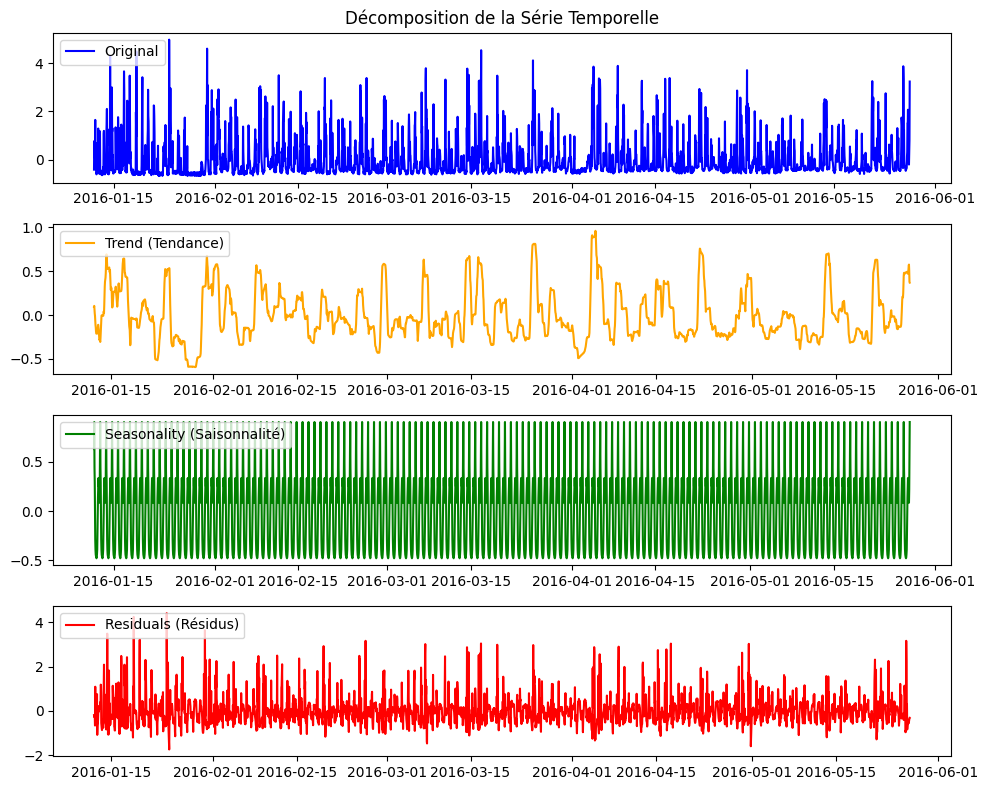

In [206]:
#data.set_index("date",inplace=True)
hourly_data = data.resample("h").mean()

# Décomposition de la série temporelle
result = seasonal_decompose(hourly_data['Appliances'], model='additive', period=24)

# Création d'un graphique combiné
plt.figure(figsize=(10, 8))

# Graphique de la série originale
plt.subplot(4, 1, 1)
plt.plot(hourly_data['Appliances'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Décomposition de la Série Temporelle')

# Graphique de la tendance
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend (Tendance)', color='orange')
plt.legend(loc='upper left')

# Graphique de la saisonnalité
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality (Saisonnalité)', color='green')
plt.legend(loc='upper left')

# Graphique des résidus
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals (Résidus)', color='red')
plt.legend(loc='upper left')

# Ajustements et affichage
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

def mape(y_test,y_pred):
    return np.mean(np.abs(y_test-y_pred)/y_test)

def rmse(y_test,y_pred):
    return np.mean((y_test-y_pred)**2)**0.5

#"Sin_day": np.sin((2*np.pi*(t))/142),"Sin_halfday": np.sin((2*np.pi*(t))/72), 
t = np.arange(len(hourly_data))

X = pd.DataFrame({"Temps": t,"Sin_day": np.sin((2*np.pi*(t))/142),"Sin_halfday": np.sin((2*np.pi*(t))/72), "intercept": np.ones((len(hourly_data),))})

variables_explicatives_list = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'is_holiday',
        'is_school_holiday']

#'is_weekend',
#data.set_index("date",inplace=True)

X['dimanche'] = (hourly_data.index.day == 6).astype(int)
X['samedi'] = (hourly_data.index.day == 5).astype(int)

X['is_12th_hour'] = (hourly_data.index.hour == 12).astype(int)  # Indicatrice pour la 12e heure
X['is_17th_hour'] = (hourly_data.index.hour == 17).astype(int)  # Indicatrice pour la 17e heure


X[variables_explicatives_list] = hourly_data[variables_explicatives_list].copy().to_numpy()

y = hourly_data["Appliances"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

model = ElasticNet()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(f"Le MAPE est {mape(y_test.to_numpy(),y_pred)}")
print(f"Le RMSE est {rmse(y_test.to_numpy(),y_pred)}")

# Create the figure
fig = go.Figure()

# Add the second line
fig.add_trace(go.Scatter(x=hourly_data.index[:len(y_pred)], y=y_test, mode='lines', name='Test'))

# Add the first line
fig.add_trace(go.Scatter(x=hourly_data.index[:len(y_pred)], y=y_pred, mode='lines', name='Prédiction'))

# Customize layout
fig.update_layout(
    title="Prédiction regression linéaire",
    xaxis_title="X-axis Label",
    yaxis_title="Y-axis Label",
    legend_title="Legend",
    template="plotly_white"
)

# Show the plot
fig.show()

Le MAPE est 0.4725550277788355
Le RMSE est 66.32242251651867
